In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import pandas as pd

# load the dataset
df = pd.read_csv("final_data.csv")

print("Column names:")
print(df.columns.tolist())

print("\nPreview of the first 5 rows:")
print(df.head())
print(df.info())


Column names:
['subject', 'ACC_0_mean', 'ACC_0_std', 'ACC_0_min', 'ACC_0_max', 'ACC_1_mean', 'ACC_1_std', 'ACC_1_min', 'ACC_1_max', 'ACC_2_mean', 'ACC_2_std', 'ACC_2_min', 'ACC_2_max', 'ECG_0_mean', 'ECG_0_std', 'ECG_0_min', 'ECG_0_max', 'HRV_CVNN', 'HRV_MCVNN', 'HRV_Prc20NN', 'HRV_pNN20', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_PAS', 'HRV_SI', 'HRV_PI', 'HRV_C1a', 'HRV_SD1a', 'HRV_C2a', 'HRV_SDNNd', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha1_Increment', 'HRV_ApEn', 'HRV_SampEn', 'HRV_ShanEn', 'HRV_FuzzyEn', 'HRV_MSEn', 'HRV_CMSEn', 'HRV_CD', 'HRV_HFD', 'HRV_KFD', 'HRV_LZC', 'EMG_0_mean', 'EMG_0_std', 'EMG_0_min', 'EMG_0_max', 'EMG_Activation_N', 'EDA_0_std', 'EDA_0_max', 'SCR_Peaks_N', 'SCR_Peaks_Amplitude_Me

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("final_data.csv")

# keep only columns that are not global features to avoid data leakage between subjects
keep_cols = [col for col in df.columns if col.startswith(('ACC_', 'ECG_', 'EDA_', 'Resp_', 'Temp_', 'EMG_', 'SCR_'))]
keep_cols += ['subject', 'label'] 

df = df[keep_cols]

# binary classification only: baseline (1) vs stress (2)
df = df[df['label'].isin([1, 2])]
df['label'] = df['label'].map({1: 0, 2: 1})

# final arrays
subject_ids = df['subject'].values
y_all = df['label'].values
X_all = df.drop(columns=['subject', 'label']).values


In [20]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

# Training and Leave-One-Subject-Out Cross-Validation (LOSO-CV)
unique_subjects = np.unique(subject_ids)
all_reports = []
subject_accuracies = []
all_y_true = []
all_y_scores = []


for test_subject in unique_subjects:
    train_mask = subject_ids != test_subject
    test_mask = subject_ids == test_subject

    X_train, X_test = X_all[train_mask], X_all[test_mask]
    y_train, y_test = y_all[train_mask], y_all[test_mask]

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # Train + predict
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (stress)
    all_y_true.append(y_test)
    all_y_scores.append(y_proba)


    # Metrics
    acc = accuracy_score(y_test, y_pred)
    subject_accuracies.append(acc)

    print(f"\nSubject {test_subject} — Test size: {len(y_test)}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.3f}")

    all_reports.append((y_test, y_pred))



Subject S10 — Test size: 63
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        39
           1       0.86      1.00      0.92        24

    accuracy                           0.94        63
   macro avg       0.93      0.95      0.93        63
weighted avg       0.95      0.94      0.94        63

Accuracy: 0.937

Subject S11 — Test size: 63
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.96      1.00      0.98        23

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.98      0.98      0.98        63

Accuracy: 0.984

Subject S13 — Test size: 62
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        40
           1       0.95      0.95      0.95        22

    accuracy                           0.97        62
   macro 

In [21]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Combine all test predictions
all_y_true = np.hstack([yt for yt, yp in all_reports])
all_y_pred = np.hstack([yp for yt, yp in all_reports])

# Get per-class precision, recall, F1, and support
precision, recall, f1, support = precision_recall_fscore_support(all_y_true, all_y_pred, average=None, labels=[0, 1])
labels = ['Non-Stress (0)', 'Stress (1)']

# Print per-class metrics
print("\n Per-Class LOSO Results:")
for i in range(len(labels)):
    print(f"{labels[i]:<20} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1 Score: {f1[i]:.3f} | Support: {support[i]}")

# Macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='weighted')
overall_accuracy = accuracy_score(all_y_true, all_y_pred)
avg_subject_accuracy = np.mean(subject_accuracies)

print("\nMacro Average:")
print(f"Precision: {precision_macro:.3f} | Recall: {recall_macro:.3f} | F1 Score: {f1_macro:.3f}")

print("\nWeighted Average:")
print(f"Precision: {precision_weighted:.3f} | Recall: {recall_weighted:.3f} | F1 Score: {f1_weighted:.3f}")

print(f"\n Overall Accuracy: {overall_accuracy:.3f}")
print(f" Average Accuracy across subjects: {avg_subject_accuracy:.3f}")



 Per-Class LOSO Results:
Non-Stress (0)       | Precision: 0.898 | Recall: 0.889 | F1 Score: 0.894 | Support: 587
Stress (1)           | Precision: 0.808 | Recall: 0.822 | F1 Score: 0.815 | Support: 332

Macro Average:
Precision: 0.853 | Recall: 0.856 | F1 Score: 0.854

Weighted Average:
Precision: 0.866 | Recall: 0.865 | F1 Score: 0.865

 Overall Accuracy: 0.865
 Average Accuracy across subjects: 0.864


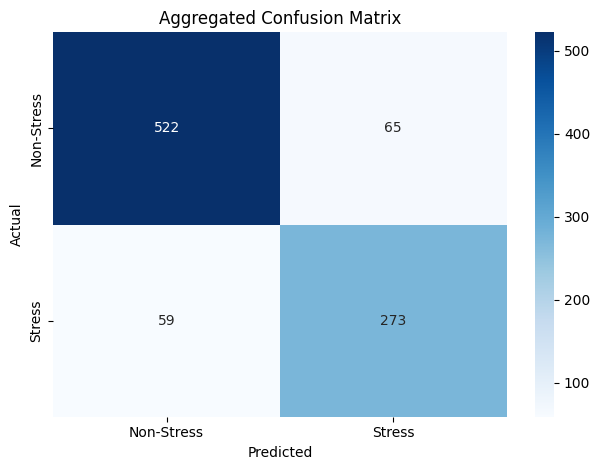

In [22]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix graph

all_y_true = np.hstack([yt for yt, yp in all_reports])
all_y_pred = np.hstack([yp for yt, yp in all_reports])

cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stress', 'Stress'], yticklabels=['Non-Stress', 'Stress'])
plt.title('Aggregated Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('aggregated-cf-matrix.png', dpi=300, bbox_inches='tight')
plt.show()


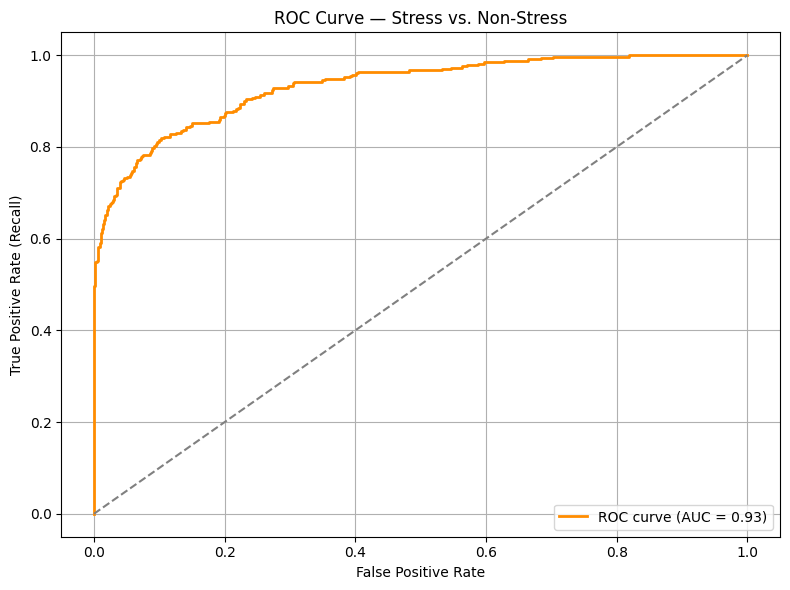

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate ROC curve plot

y_true = np.hstack(all_y_true)
y_scores = np.hstack(all_y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — Stress vs. Non-Stress")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('roccurve.png')
plt.show()


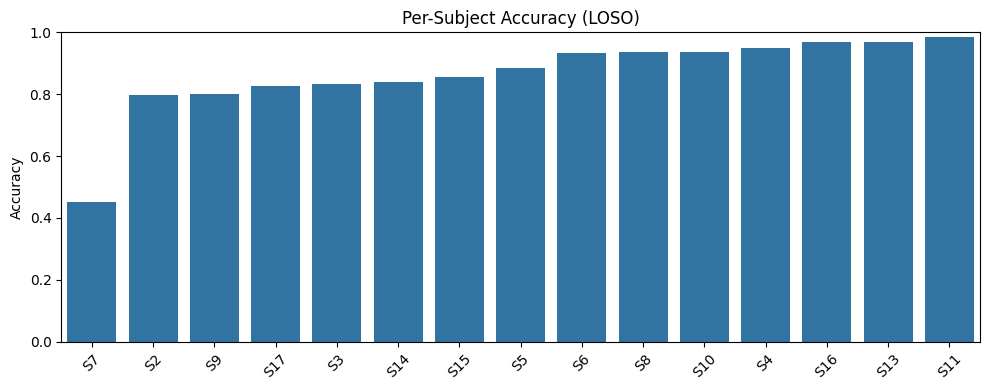

In [24]:
# Generate plot to show each subject's individual accuracy

subject_acc_data = list(zip(unique_subjects, subject_accuracies))
subject_acc_data.sort(key=lambda x: x[1])  # sort for better visual

subjects_sorted, accs_sorted = zip(*subject_acc_data)

plt.figure(figsize=(10, 4))
sns.barplot(x=list(subjects_sorted), y=list(accs_sorted))
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Subject Accuracy (LOSO)")
plt.tight_layout()
plt.savefig('per-subject-accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
